#XMAP plotter

##Helping hands

http://nbviewer.ipython.org/github/herrfz/dataanalysis/blob/master/week2/getting_data.ipynb

http://nbviewer.ipython.org/github/jvns/pandas-cookbook/blob/master/cookbook/Chapter%201%20-%20Reading%20from%20a%20CSV.ipynb


##Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#import matplotlib as plt
#plt.use('TkAgg') 

import operator

import pylab
pylab.show()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


##Definitions

In [37]:
fileUrl = "../S_lycopersicum_chromosomes.2.50.BspQI_to_EXP_REFINEFINAL1_xmap.txt"
MIN_CONF = 10.0
FULL_FIG_W , FULL_FIG_H  = 16, 8
CHROM_FIG_W, CHROM_FIG_H = FULL_FIG_W, 20

##Setup

###Figure sizes controller

In [4]:
class size_controller(object):
    def __init__(self, w, h):
        self.w = w
        self.h = h
        
    def __enter__(self):
        self.o = rcParams['figure.figsize']
        rcParams['figure.figsize'] = self.w, self.h
        return None
    
    def __exit__(self, type, value, traceback):
        rcParams['figure.figsize'] = self.o

###Column type definition

In [21]:
col_type_int = np.int64
col_type_flo = np.float64
col_type_str = np.object
col_info =[
    [ "XmapEntryID" , col_type_int ],
    [ "QryContigID" , col_type_int ],
    [ "RefContigID" , col_type_int ],
    [ "QryStartPos" , col_type_flo ],
    [ "QryEndPos"   , col_type_flo ],
    [ "RefStartPos" , col_type_flo ],
    [ "RefEndPos"   , col_type_flo ],
    [ "Orientation" , col_type_str ],
    [ "Confidence"  , col_type_flo ],
    [ "HitEnum"     , col_type_str ],
    [ "QryLen"      , col_type_flo ],
    [ "RefLen"      , col_type_flo ],
    [ "LabelChannel", col_type_str ],
    [ "Alignment"   , col_type_str ],
]

col_names=[cf[0] for cf in col_info]
col_types=dict(zip([c[0] for c in col_info], [c[1] for c in col_info]))
col_types


{'Alignment': object,
 'Confidence': numpy.float64,
 'HitEnum': object,
 'LabelChannel': object,
 'Orientation': object,
 'QryContigID': numpy.int64,
 'QryEndPos': numpy.float64,
 'QryLen': numpy.float64,
 'QryStartPos': numpy.float64,
 'RefContigID': numpy.int64,
 'RefEndPos': numpy.float64,
 'RefLen': numpy.float64,
 'RefStartPos': numpy.float64,
 'XmapEntryID': numpy.int64}

##Read GFF

###Parse INFO column

In [5]:
info_keys = set()

def filter_conv(fi):
    global info_keys
    vs = []
    for pair in fi.split(";"):
        kv = pair.split("=")
        info_keys.add(kv[0])
        
        if len(kv) == 2:
            #in case of key/value pairs
            vs.append(kv)
        else:
            #in case of flags such as INDEL
            vs.append([kv[0], True])
         
    x = dict(zip([x[0] for x in vs], [x[1] for x in vs]))
    #z = pd.Series(x)
    #print z
    return x

###Read XMAP
http://nbviewer.ipython.org/github/herrfz/dataanalysis/blob/master/week2/getting_data.ipynb

In [26]:
CONVERTERS = {
    'info': filter_conv
}
SKIP_ROWS = 9
NROWS     = None
gffData = pd.read_csv(fileUrl, names=col_names, index_col='XmapEntryID', dtype=col_types, header=None, skiprows=SKIP_ROWS, delimiter="\t", comment="#", verbose=True, nrows=NROWS)
gffData.head()

Tokenization took: 9.10 ms
Type conversion took: 22.83 ms
Parser memory cleanup took: 0.01 ms


QryContigID  RefContigID  QryStartPos  QryEndPos  RefStartPos  \
XmapEntryID                                                                  
1                    141            1     528400.6   571697.5      10672.0   
2                    174            1      21236.5  1568390.0      10672.0   
3                   1129            1     444677.7   340490.1      52972.0   
4                     42            1    1439722.2  1522476.2      54237.5   
5                   1752            1     210082.7   158973.4      55635.0   

             RefEndPos Orientation  Confidence  \
XmapEntryID                                      
1              54237.5           +        6.65   
2            1553561.0           +       79.35   
3             154578.0           -        9.08   
4             135860.0           +        7.53   
5             106448.0           -        6.59   

                                                       HitEnum     QryLen  \
XmapEntryID                                                                 
1                                                       4M2D2M  1439123.5   
2            2M3D1M1D1M1D4M1I2M1D2M1D1M2I2D9M3I3M1D6M1D2M2D...  1568410.0   
3                                                   4M1D2M1D2M   650802.9   
4                                                       6M1D1M  2153950.0   
5                                                           5M   703838.0   

               RefLen LabelChannel  \
XmapEntryID                          
1            21805821            1   
2            21805821            1   
3            21805821            1   
4            21805821            1   
5            21805821            1   

                                                     Alignment  
XmapEntryID                                                     
1             (1,34)(2,34)(3,35)(4,36)(5,37)(6,38)(8,38)(9,39)  
2            (1,2)(2,2)(3,3)(6,4)(7,4)(9,5)(11,6)(12,7)(13,...  
3            (6,27)(8,27)(9,26)(10,25)(11,24)(13,23)(14,22)...  
4            (7,99)(9,99)(10,100)(11,101)(12,102)(13,103)(1...  
5                          (10,15)(11,14)(12,13)(13,12)(14,11)

###Add length column

In [38]:
gffData['qry_match_len'] = abs(gffData['QryEndPos'] - gffData['QryStartPos'])
gffData['ref_match_len'] = abs(gffData['RefEndPos'] - gffData['RefStartPos'])
gffData['match_prop'   ] = gffData['qry_match_len'] / gffData['ref_match_len']
gffData = gffData[gffData['Confidence'] >= MIN_CONF]
#del gffData['HitEnum']
#del gffData['Alignment']
#del gffData['LabelChannel']
gffData.head()

QryContigID  RefContigID  QryStartPos  QryEndPos  RefStartPos  \
XmapEntryID                                                                  
2                    174            1      21236.5  1568390.0        10672   
32                   430            1         20.0   651018.8      1493902   
49                   877            1     185486.6       20.0      2289130   
53                   563            1     614521.1       20.0      2470486   
63                   276            1     599215.1   211191.6      3450761   

             RefEndPos Orientation  Confidence     QryLen    RefLen  qry_match_len  \
XmapEntryID                                                                          
2              1553561           +       79.35  1568410.0  21805821      1547153.5   
32             2123769           +       48.60   651038.8  21805821       650998.8   
49             2470486           -       13.00   803876.2  21805821       185466.6   
53             3076619           -       39.72   614541.2  21805821       614501.1   
63             3837771           -       18.32  1006781.1  21805821       388023.5   

             ref_match_len  match_prop  
XmapEntryID                             
2                  1542889    1.002764  
32                  629867    1.033550  
49                  181356    1.022666  
53                  606133    1.013806  
63                  387010    1.002619

##Good part

http://nbviewer.ipython.org/github/jvns/pandas-cookbook/blob/master/cookbook/Chapter%201%20-%20Reading%20from%20a%20CSV.ipynb

http://pandas.pydata.org/pandas-docs/dev/visualization.html

https://bespokeblog.wordpress.com/2011/07/11/basic-data-plotting-with-matplotlib-part-3-histograms/

http://nbviewer.ipython.org/github/mwaskom/seaborn/blob/master/examples/plotting_distributions.ipynb

http://nbviewer.ipython.org/github/herrfz/dataanalysis/blob/master/week3/exploratory_graphs.ipynb

http://pandas.pydata.org/pandas-docs/version/0.15.0/visualization.html

http://www.gregreda.com/2013/10/26/working-with-pandas-dataframes/

###Column types

In [39]:
gffData.dtypes

QryContigID        int64
RefContigID        int64
QryStartPos      float64
QryEndPos        float64
RefStartPos      float64
RefEndPos        float64
Orientation       object
Confidence       float64
QryLen           float64
RefLen           float64
qry_match_len    float64
ref_match_len    float64
match_prop       float64

###Global statistics

In [49]:
gffData[['Confidence', 'QryLen', 'qry_match_len', 'ref_match_len', 'match_prop']].describe()

Confidence          QryLen   qry_match_len   ref_match_len  match_prop
count  806.000000      806.000000      806.000000      806.000000  806.000000
mean    44.394392  1060730.885980   806780.455087   808579.419727    1.005254
std     35.102060   766822.634245   666725.902594   696117.713781    0.057103
min     10.000000   159278.100000    37937.300000    40836.000000    0.382891
25%     20.062500   562829.150000   353944.375000   345101.875000    1.001254
50%     35.370000   838241.600000   653258.100000   645086.500000    1.006935
75%     58.787500  1314064.700000  1048673.200000  1037459.000000    1.014043
max    314.540000  5480650.900000  5480610.800000  7038108.000000    1.421166

###List of chromosomes

In [41]:
chromosomes = np.unique(gffData['RefContigID'].values)
chromosomes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

###Quality distribution

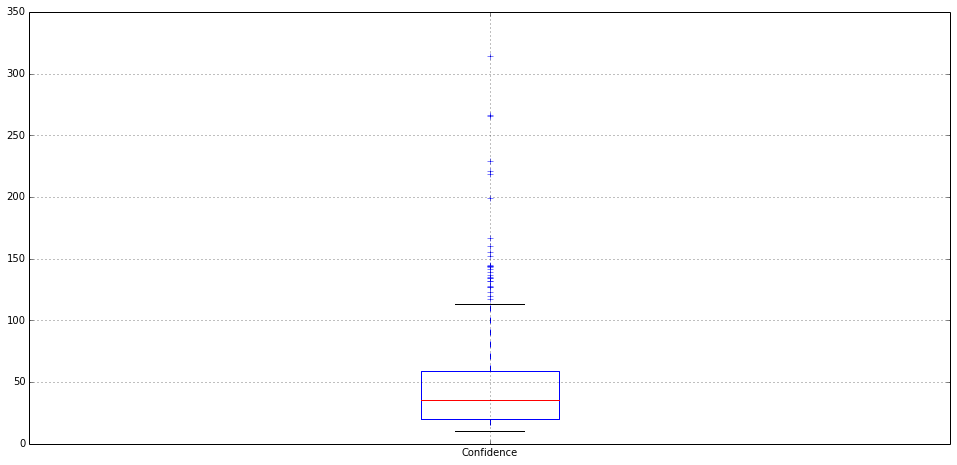

In [42]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    bq = gffData.boxplot(column='Confidence')

###Quality distribution per chromosome

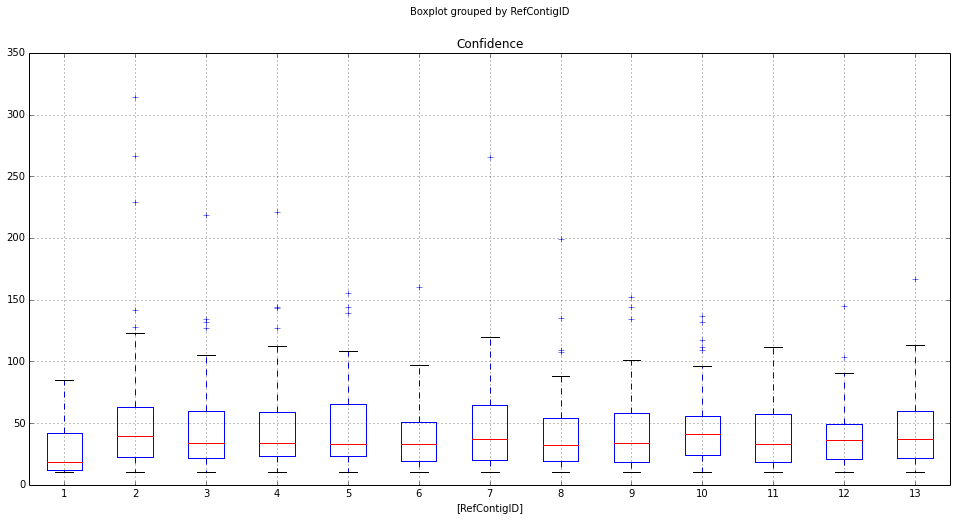

In [43]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    bqc = gffData.boxplot(column='Confidence', by='RefContigID')

###Position distribution

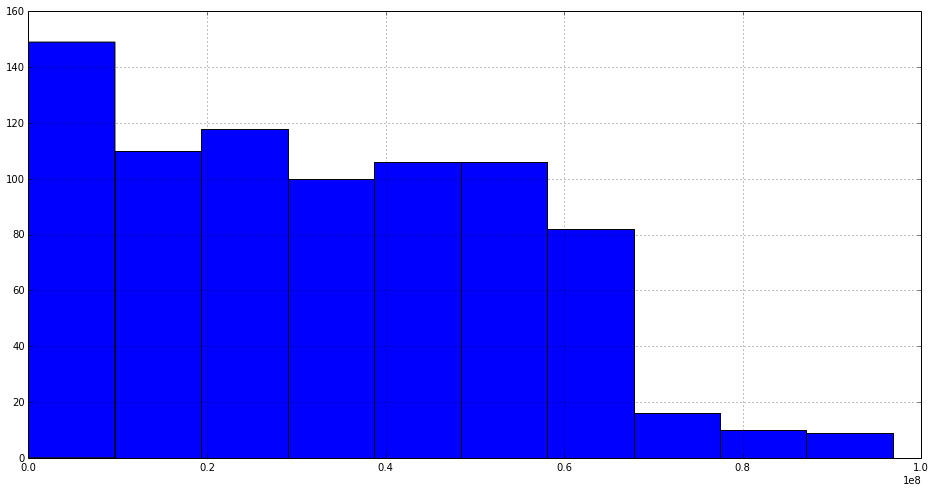

In [44]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    hs = gffData['RefStartPos'].hist()

###Position distribution per chromosome

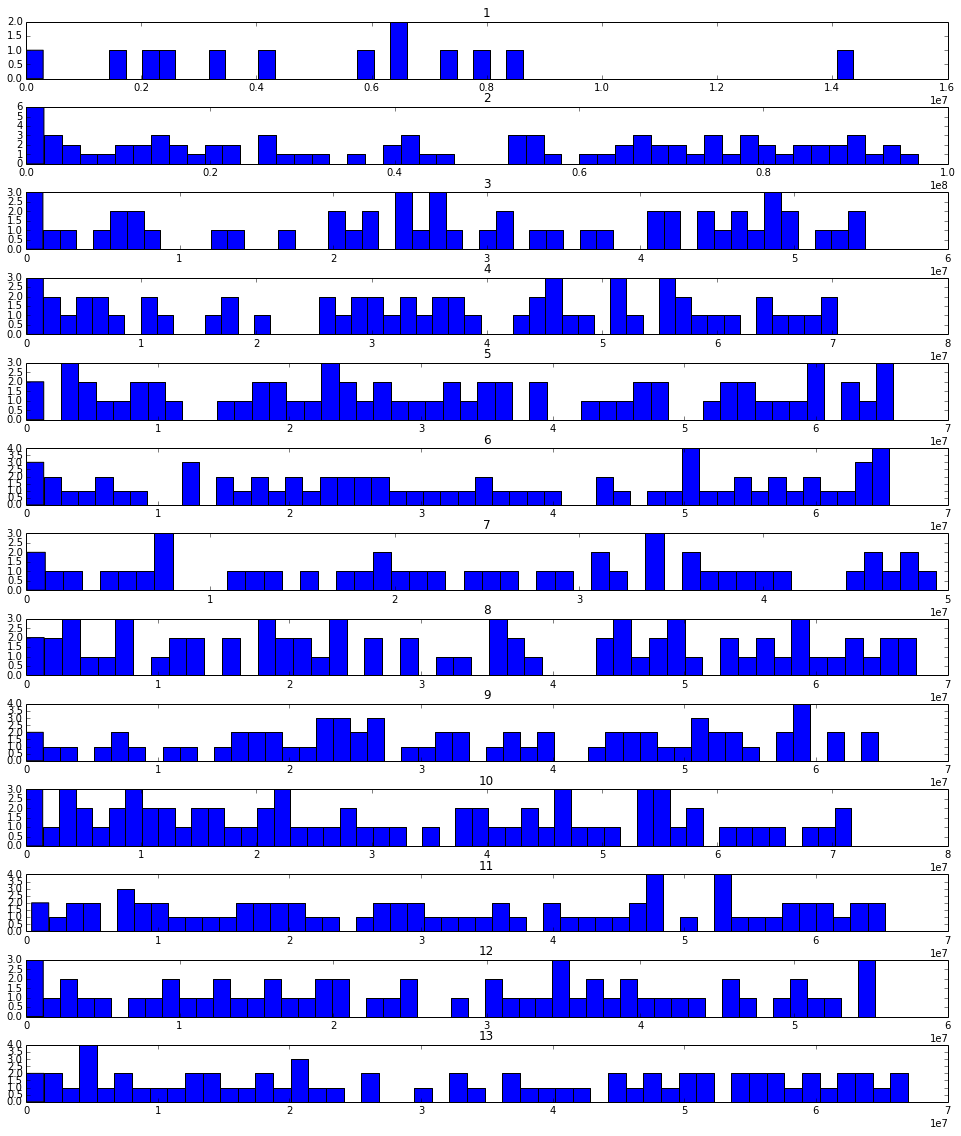

In [45]:
hsc = gffData['RefStartPos'].hist(by=gffData['RefContigID'], figsize=(CHROM_FIG_W, CHROM_FIG_H), layout=(len(chromosomes),1)) 

###Length distribution

In [46]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    hl = gffData['qry_match_len'].hist()

###Length distribution per chromosome

In [47]:
hlc = gffData['qry_match_len'].hist(by=gffData['RefContigID'], figsize=(CHROM_FIG_W, CHROM_FIG_H), layout=(len(chromosomes),1))